In [6]:
from keras.datasets import mnist
from datasets import nmnist
from sklearn.metrics import accuracy_score
from keras import backend as K
import keras

import numpy as np
from matplotlib import pyplot as plt
import random

from gaussiannets import ProbabilisticCNN

def print_digit(digit_data, raw_class_prob, class_prob_distr):
    class_prob_median, class_prob_std = class_prob_distr
    two_d = (np.reshape(digit_data, (28, 28)) * 255).astype(np.uint8)
    full_figure = plt.figure(figsize=(15, 10))
    full_figure.add_subplot(231)
    plt.imshow(two_d, cmap='gray')
    full_figure.add_subplot(232)
    plt.bar(range(10), raw_class_prob)
    plt.xticks(range(10), range(10))
    full_figure.add_subplot(233)
    plt.bar(range(10), class_prob_median, yerr=class_prob_std)
    plt.xticks(range(10), range(10))
    plt.show()

def labels_from_probs(class_probs, class_std=None, alpha=1):
    if class_std is None:
        return np.argmax(class_probs, axis=1)
    else:
        candidates = []
        for prob_vector, std_vector in zip(class_probs, class_std):
            candidate = np.argmax(prob_vector)
            for digit in range(len(prob_vector)):
                if digit != candidate and \
                   prob_vector[candidate] - alpha*std_vector[candidate] < \
                                            prob_vector[digit] + alpha * std_vector[digit]:
                        candidate = -1
                        break
            candidates.append(candidate)
        return np.array(candidates)
    
    
def uncertain_score(y_true, y_predicted, penalty=1, reward=1):
    score = 0
    for label_true, label_predicted in zip(y_true, y_predicted):
        if label_predicted == -1:
            pass
        elif label_predicted == label_true:
            score += reward
        else:
            score -= penalty
    return score

    
save_path = "weights.pkl"                #Path to serialize the model. If none it will not serialize it
load_path = None      #Path to load a serialized model. If none it will retrain from scratch

## MNIST 

We run the Gaussian CNN with the standard MNIST dataset to check how it fares with 

In [7]:
# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# input image dimensions
img_rows, img_cols = 28, 28

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

y_train_m = keras.utils.to_categorical(y_train, 10)

model = ProbabilisticCNN(input_shape, 10, epochs=9, baseline=True)
if load_path is not None:
    model.load(load_path, x_train, y_train_m)
else:
    model.fit(x_train, y_train_m)

if save_path is not None:
    model.save(save_path)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Epoch 1/9
 5504/60000 [=>............................] - ETA: 1:32 - loss: 0.9561 - acc: 0.6969

KeyboardInterrupt: 

In [10]:
class_prob_dist = np.array(model.predict(x_test))
class_prob_raw = model.predict(x_test, raw_predict=True)

y_predict_all = labels_from_probs(class_prob_dist[0])
y_predict_unc = labels_from_probs(class_prob_dist[0], class_prob_dist[1], 1)
y_predict_raw = labels_from_probs(class_prob_raw)

acc_raw = accuracy_score(y_test, y_predict_raw)
acc_gaussian = accuracy_score(y_test, y_predict_all)

score_raw = uncertain_score(y_test, y_predict_raw, 5)
score_gaussian = uncertain_score(y_test, y_predict_unc, 5)
print('CNN accuracy: %4f, GaussianCNN accuracy: %4f' % (acc_raw, acc_gaussian))
print('CNN score: %d, GuassianCNN score: %d' % (score_raw, score_gaussian))

CNN accuracy: 0.991700, GaussianCNN accuracy: 0.992200
CNN score: 9502, GuassianCNN score: 9607


The difference between the raw CNN and the gaussian CNN is particularly noticable in the more "unclear" images

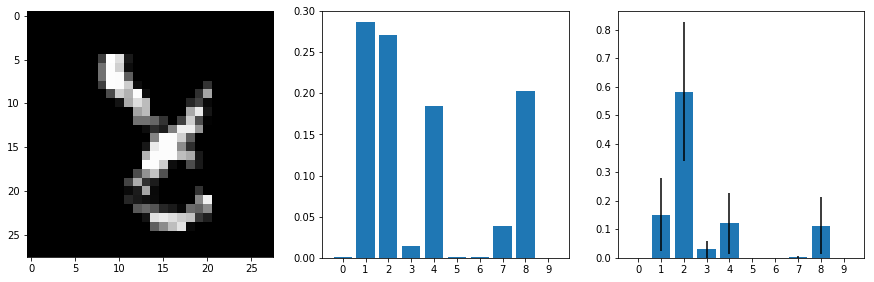

In [4]:
worst_results = np.argsort(np.max(class_prob_raw, axis=1))[:10]
random_digit = random.choice(worst_results)
print_digit(x_test[random_digit], class_prob_raw[random_digit], class_prob_dist[:, random_digit])

## N-MNIST

The Neuromorphic-MNIST (N-MNIST) dataset is a spiking version of the original frame-based MNIST dataset. We will now see what role uncernanty plays when the test set is very noisy compared to the training set

In [5]:
# the data, shuffled and split between train and test sets
_, (n_x_test, n_y_test_m) = nmnist.load_data()

if K.image_data_format() == 'channels_first':
    n_x_test = n_x_test.reshape(n_x_test.shape[0], 1, img_rows, img_cols)
else:
    n_x_test = n_x_test.reshape(n_x_test.shape[0], img_rows, img_cols, 1)
    
n_x_test = n_x_test.astype('float32')
n_x_test /= 255

print(n_x_test.shape[0], 'test samples')

n_y_test = np.argmax(n_y_test_m, axis=1)

n_class_prob_dist= np.array(model.predict(n_x_test))
n_class_prob_raw = model.predict(n_x_test, raw_predict=True)

n_y_predict_unc = np.argmax(n_class_prob_dist[0], axis=1)
n_y_predict_raw = np.argmax(n_class_prob_raw, axis=1)

score_raw = accuracy_score(n_y_test, n_y_predict_raw)
score_gaussian = accuracy_score(n_y_test, n_y_predict_unc)

print('CNN accuracy', score_raw)
print('ProbabilisticCNN accuracy', score_gaussian)

10000 test samples
CNN accuracy 0.7254
ProbabilisticCNN accuracy 0.6577


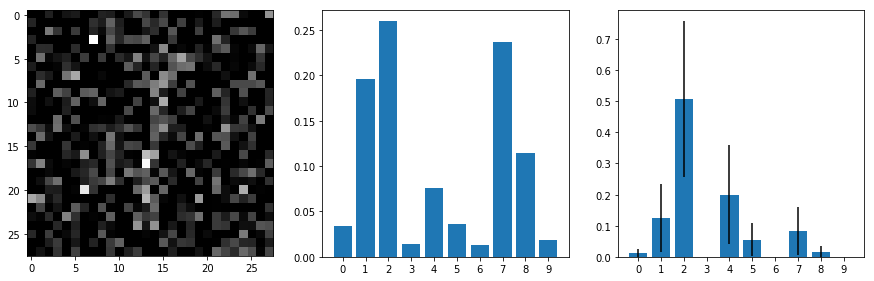

In [23]:
worst_results = np.argsort(np.max(n_class_prob_raw, axis=1))[100:1000]
random_digit = random.choice(worst_results)
print_digit(n_x_test[random_digit], n_class_prob_raw[random_digit], n_class_prob_dist[:, random_digit])